In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
import os, random, warnings
warnings.filterwarnings('ignore')

In [2]:
image_shape = (224, 224)
batch_size = 32
epochs = 10
data_path = 'C:/Users/Ania/Desktop/dataset2/archive (1)/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)'
train_folder = os.path.join(data_path, 'train')
valid_folder = os.path.join(data_path, 'valid')

In [5]:
train_datagen = ImageDataGenerator(rescale=1/255., validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data = train_datagen.flow_from_directory(train_folder, target_size=image_shape, batch_size=batch_size, class_mode='categorical', subset='training')
valid_data = train_datagen.flow_from_directory(train_folder, target_size=image_shape, batch_size=batch_size, class_mode='categorical', subset='validation')
test_data = test_datagen.flow_from_directory(valid_folder, target_size=image_shape, batch_size=batch_size, class_mode='categorical')

Found 112488 images belonging to 38 classes.
Found 28102 images belonging to 38 classes.
Found 35144 images belonging to 38 classes.


In [7]:
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Zamrażamy warstwy

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
predictions = Dense(train_data.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,596,710 (9.91 MB)

 Trainable params: 338,214 (1.29 MB)

 Non-trainable params: 2,258,496 (8.62 MB)

In [9]:
#trenowanie
checkpoint = ModelCheckpoint('mobilenetv2_best.keras', save_best_only=True, monitor='val_accuracy', mode='max')
early_stop = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
history = model.fit(train_data, validation_data=valid_data, epochs=epochs, callbacks=[checkpoint, early_stop])

Epoch 1/10
3516/3516 ━━━━━━━━━━━━━━━━━━━━ 2689s 763ms/step - accuracy: 0.6931 - loss: 1.1587 - val_accuracy: 0.9283 - val_loss: 0.2400
Epoch 2/10
3516/3516 ━━━━━━━━━━━━━━━━━━━━ 2660s 756ms/step - accuracy: 0.9391 - loss: 0.2082 - val_accuracy: 0.9426 - val_loss: 0.1790
Epoch 3/10
3516/3516 ━━━━━━━━━━━━━━━━━━━━ 2641s 751ms/step - accuracy: 0.9616 - loss: 0.1303 - val_accuracy: 0.9466 - val_loss: 0.1616
Epoch 4/10
3516/3516 ━━━━━━━━━━━━━━━━━━━━ 2636s 750ms/step - accuracy: 0.9719 - loss: 0.0946 - val_accuracy: 0.9544 - val_loss: 0.1403
Epoch 5/10
3516/3516 ━━━━━━━━━━━━━━━━━━━━ 2644s 752ms/step - accuracy: 0.9784 - loss: 0.0733 - val_accuracy: 0.9547 - val_loss: 0.1423
Epoch 6/10
3516/3516 ━━━━━━━━━━━━━━━━━━━━ 2641s 751ms/step - accuracy: 0.9839 - loss: 0.0570 - val_accuracy: 0.9547 - val_loss: 0.1461
Epoch 7/10
3516/3516 ━━━━━━━━━━━━━━━━━━━━ 2678s 762ms/step - accuracy: 0.9853 - loss: 0.0496 - val_accuracy: 0.9551 - val_loss: 0.1444
Epoch 8/10
3516/3516 ━━━━━━━━━━━━━━━━━━━━ 2675s 761ms/s

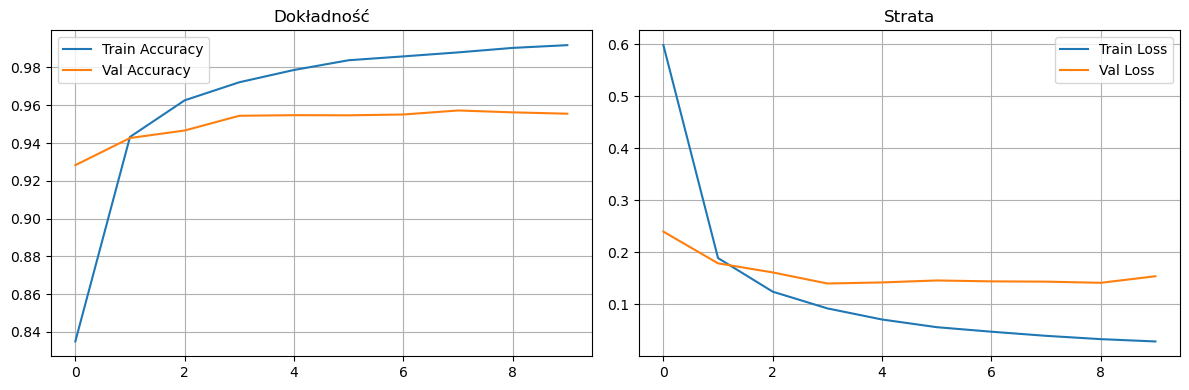

In [11]:
#krzywe uczenia
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend(), plt.grid(), plt.title('Dokładność')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(), plt.grid(), plt.title('Strata')
plt.tight_layout()
plt.show()

In [13]:
best_model = tf.keras.models.load_model('mobilenetv2_best.keras')
test_loss, test_acc = best_model.evaluate(test_data)
print(f'Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}')

1099/1099 ━━━━━━━━━━━━━━━━━━━━ 668s 605ms/step - accuracy: 0.9668 - loss: 0.1045
Test Accuracy: 0.9677, Test Loss: 0.1030


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


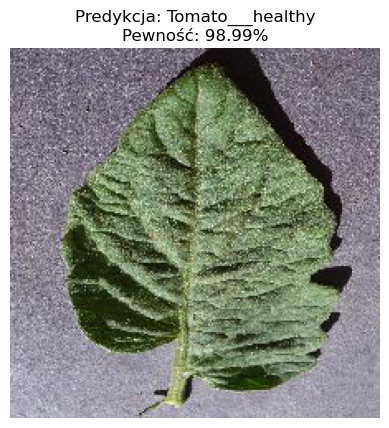

In [15]:

model_path = 'mobilenetv2_best.keras'
image_path = 'C:/Users/Ania/Desktop/dataset/PlantVillage/val/Tomato___healthy/0f9a114d-1df8-442c-90e7-d14d2f6efb23___RS_HL 9964.jpg'  # ścieżka do obrazka
image_size = (224, 224)  #rozmiar zgodny z wejściem modelu

#wczyta model
model = load_model(model_path)

#pobieranie i przygotownie obrazka
img = load_img(image_path, target_size=image_size)
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

#predykcja
prediction = model.predict(img_array)
predicted_index = np.argmax(prediction)
confidence = prediction[0][predicted_index]
#pokaż wynik
class_labels = list(train_data.class_indices.keys())
predicted_label = class_labels[predicted_index]
plt.imshow(img)
plt.axis('off')
plt.title(f"Predykcja: {predicted_label}\nPewność: {confidence*100:.2f}%")
plt.show()


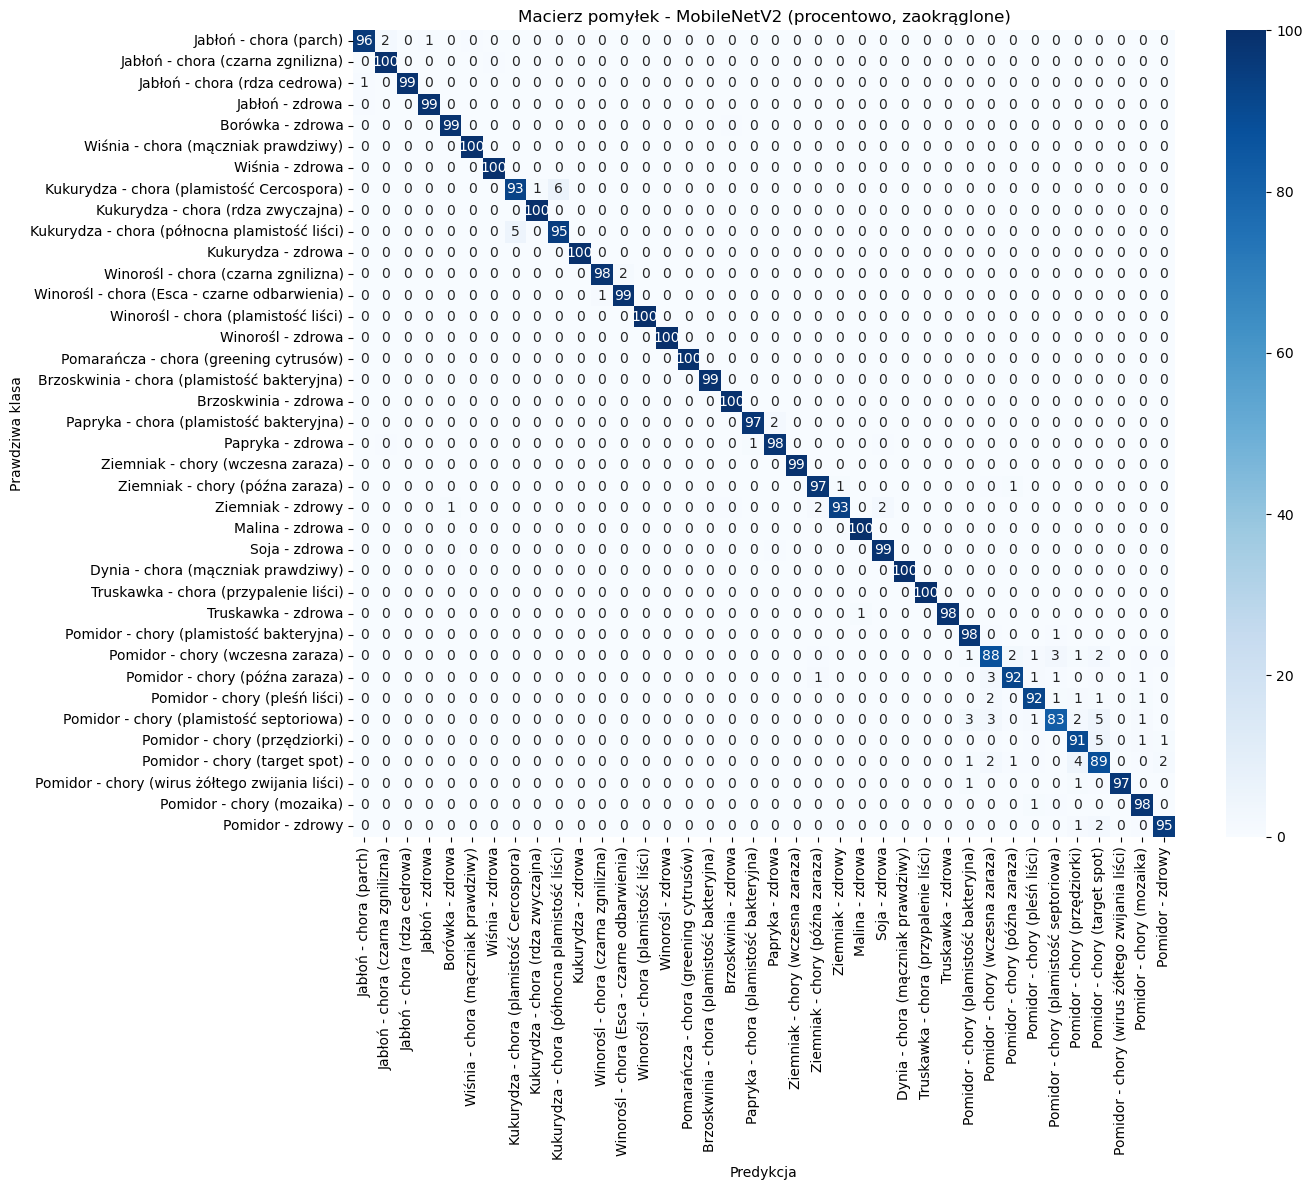

In [29]:
model = load_model("mobilenetv2_best.keras")

# Klasy (nazwy katalogów testowych)
class_names = list(test_data.class_indices.keys())

# Przewidywanie batchami
y_true = []
y_pred = []

for i in range(len(test_data)):
    x_batch, y_batch = test_data[i]
    preds = model.predict(x_batch, verbose=0)

    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

    if (i + 1) * test_data.batch_size >= test_data.samples:
        break

class_names_pl = [
    'Jabłoń - chora (parch)', 'Jabłoń - chora (czarna zgnilizna)', 'Jabłoń - chora (rdza cedrowa)', 'Jabłoń - zdrowa',
    'Borówka - zdrowa', 'Wiśnia - chora (mączniak prawdziwy)', 'Wiśnia - zdrowa',
    'Kukurydza - chora (plamistość Cercospora)', 'Kukurydza - chora (rdza zwyczajna)',
    'Kukurydza - chora (północna plamistość liści)', 'Kukurydza - zdrowa',
    'Winorośl - chora (czarna zgnilizna)', 'Winorośl - chora (Esca - czarne odbarwienia)',
    'Winorośl - chora (plamistość liści)', 'Winorośl - zdrowa',
    'Pomarańcza - chora (greening cytrusów)', 'Brzoskwinia - chora (plamistość bakteryjna)',
    'Brzoskwinia - zdrowa', 'Papryka - chora (plamistość bakteryjna)', 'Papryka - zdrowa',
    'Ziemniak - chory (wczesna zaraza)', 'Ziemniak - chory (późna zaraza)', 'Ziemniak - zdrowy',
    'Malina - zdrowa', 'Soja - zdrowa', 'Dynia - chora (mączniak prawdziwy)',
    'Truskawka - chora (przypalenie liści)', 'Truskawka - zdrowa',
    'Pomidor - chory (plamistość bakteryjna)', 'Pomidor - chory (wczesna zaraza)', 'Pomidor - chory (późna zaraza)',
    'Pomidor - chory (pleśń liści)', 'Pomidor - chory (plamistość septoriowa)',
    'Pomidor - chory (przędziorki)', 'Pomidor - chory (target spot)',
    'Pomidor - chory (wirus żółtego zwijania liści)', 'Pomidor - chory (mozaika)', 'Pomidor - zdrowy'
]

#macierz pomyłek
cm = confusion_matrix(y_true, y_pred)

#normalizowana w % (zaokrąglona)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

#pokaż macierz
plt.figure(figsize=(14, 12))
sns.heatmap(cm_normalized, annot=True, fmt='.0f', cmap='Blues',
            xticklabels=class_names_pl, yticklabels=class_names_pl)
plt.title("Macierz pomyłek - MobileNetV2 (procentowo, zaokrąglone)")
plt.xlabel("Predykcja")
plt.ylabel("Prawdziwa klasa")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

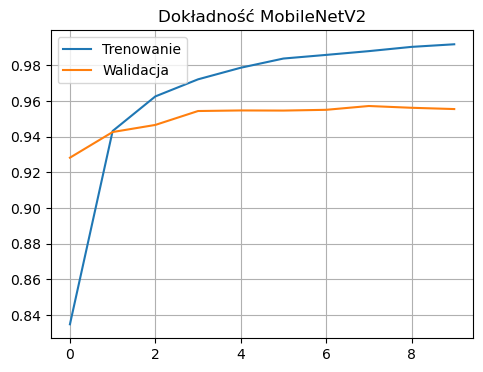

In [33]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Trenowanie')
plt.plot(history.history['val_accuracy'], label='Walidacja')
plt.legend(), plt.grid(), plt.title('Dokładność MobileNetV2')

plt.show()